In [1]:
# from deap import base, creator, tools, algorithms
from dedalus import public as de
from dedalus.extras.plot_tools import plot_bot_2d
from dedalus.extras import *
import numpy as np
import scipy
from scipy import integrate
import pickle
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd

import time as timeski
import os

#Suppress most Dedalus output
de.logging_setup.rootlogger.setLevel('ERROR')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
# rcParams['font.sans-serif'] = ['Tahoma']
rcParams.update({'font.size': 16})

In [8]:
###################################################################
# Simulation Functions
###################################################################

#Scale list between 0 and 1
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

# steady state ODE
def ssODE(y,t,params):
    u,v,g,G = y
    b,gamma,n,delta,e,c,d,K = params
    
    du = b*v+v*gamma*u**n/(K**n+u**n)-delta*u-e*G*u
    dv = -du
    
    dG = c*u*g-d*G
    dg = - dG
    
    derivs = [du,dv,dg,dG]
    return derivs

#determine homogenous SS using ssODE
def homogenousSS(u,v,g,G,params):

    y0 = (u,v,g,G)
    t_sim = (0,1000)
    odeSoln = integrate.odeint(ssODE,y0,t_sim,args=(params,),mxstep=1000000) 
      
    return(odeSoln[1])

def logistic_decay(x,p_min,p_max,k,x0=1.75):  
    #positive k -> decay
    p_amp = p_max - p_min
    return p_min+p_amp/(1+np.exp(k*(x-x0)))

def WPGAP(params,plot_bool=False):
    c_p,c_m,gamma_p,gamma_m,e,d = params
    
    #if using scale factor to scale GTPase concentration
    scale_f = 200
    
    #Fixed parameters
    b = 0.002
    c_s = 1/scale_f
    gamma_s = 0.005
    delta = 0.4
    
    c_p = c_p/scale_f
    

    #Bases:names,modes,intervals,dealiasing
    phi_basis=de.Fourier('p',256,interval=(0,2*np.pi),dealias=3/2)
    r_basis=de.Chebyshev('r',128,interval=(0,4),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([phi_basis,r_basis],float)
    phi, r = domain.grids(scales=1)

    mu_F = 1.75

    c = domain.new_field(name='c')
    gamma = domain.new_field(name='gamma')

    c['g'] = logistic_decay(r[0],c_s,c_p,c_m,x0=mu_F) 
    gamma['g'] = logistic_decay(r[0],gamma_s,gamma_p,gamma_m,x0=mu_F)

    c.meta['p']['constant'] = True
    gamma.meta['p']['constant'] = True

    T = 4.04*scale_f
    Tg = 10
    n = 2
    K = 1*scale_f
    Du = .04
    Dv = 100*Du
    DG = 100*Du #40
    Dg = 100*Du

    params = [b,gamma_s,n,delta,e,c_s,d,K]
    u0,v0,g0,G0 = homogenousSS(T/2,T/2, Tg/2, Tg/2,params)


    # Specify problem
    problem = de.IVP(domain, variables=['u', 'v','ur','vr','G','g','Gr','gr'])

    problem.parameters['gamma'] = gamma
    problem.parameters['b'] = b
    problem.parameters['n'] = n
    problem.parameters['u0'] = u0
    problem.parameters['v0'] = v0
    problem.parameters['G0'] = G0
    problem.parameters['g0'] = g0
    problem.parameters['c'] = c
    problem.parameters['dd'] = d
    problem.parameters['delta'] = delta
    problem.parameters['e'] = e
    problem.parameters['K'] = K
    problem.parameters['Tg'] = Tg

    problem.parameters['Du'] = Du
    problem.parameters['Dv'] = Dv
    problem.parameters['DG'] = DG
    problem.parameters['Dg'] = Dg

    problem.substitutions['f(u,v,G)'] = 'b*v+v*gamma*u**n/(K**n+u**n)-delta*u-e*G*u'
    problem.substitutions['minf(u,v,G)'] = '-f(u,v,G)'
    problem.substitutions['fg(u,G,g)'] = 'c*u*g-dd*G'
    problem.substitutions['minfg(u,G,g)'] = '-fg(u,G,g)'


    problem.add_equation("r**2*dt(u)-r**2*Du*dr(ur)-r*Du*dr(u)-Du*dp(dp(u))=r**2*f(u,v,G)")
    problem.add_equation("r**2*dt(v)-r**2*Dv*dr(vr)-r*Dv*dr(v)-Dv*dp(dp(v))=r**2*minf(u,v,G)")
    problem.add_equation("r**2*dt(G)-r**2*DG*dr(Gr)-r*DG*dr(G)-DG*dp(dp(G))=r**2*fg(u,G,g)")
    problem.add_equation("r**2*dt(g)-r**2*Dg*dr(gr)-r*Dg*dr(g)-Dg*dp(dp(g))=r**2*minfg(u,G,g)")

    problem.add_equation("ur-dr(u)=0")
    problem.add_equation("vr-dr(v)=0")
    problem.add_equation("Gr-dr(G)=0")
    problem.add_equation("gr-dr(g)=0")

    #Reflective boundary conditions

    problem.add_bc("left (ur) = 0")
    problem.add_bc("right (ur) = 0")
    problem.add_bc("left (vr) = 0")
    problem.add_bc("right (vr) = 0")
    problem.add_bc("left (Gr) = 0")
    problem.add_bc("right (Gr) = 0")
    problem.add_bc("left (gr) = 0")
    problem.add_bc("right (gr) = 0")


    # Pick a timestepper
    ts = de.timesteppers.RK443 #222
    # Build solver
    solver = problem.build_solver(ts)
    # Set integration limits
    solver.stop_wall_time = np.inf
    solver.stop_sim_time = np.inf
    solver.stop_iteration = np.inf
    # Set initial conditions
    u = solver.state ['u']
    v = solver.state['v']
    G = solver.state ['G']
    g = solver.state['g']

    urand = 0.3*v0*np.random.rand(*u['g'].shape) #0.2

    u['g'] = u0+urand
    v['g'] = v0-urand
    G['g'] = G0*np.ones(G['g'].shape)
    g['g'] = g0*np.ones(g['g'].shape)
    

# # #     ################################ For movies
#     save_name = 'MovieMCMC_Worst/mov_worst_'
#     phi, r = domain.grids(scales=1)
#     phi = np.vstack((phi,2*np.pi))
#     phi,r = np.meshgrid(phi,r)
#     z = np.vstack((u['g'],u['g'][0])).T
#     fig = plt.figure(figsize=(6,4))
#     # ax = Axes3D(fig)

#     plt.subplot(projection="polar")

#     plt.pcolormesh(phi,r, z,vmin=0., vmax = 0.8,shading='auto')

#     plt.plot(phi, r, color='k', ls='none') 
#     plt.title('t={}'.format(0))
#     plt.xticks([])
#     plt.yticks([])
#     plt.colorbar()
#     plt.savefig(save_name + '_00{}.png'.format(0),dpi=300)
#     plt.close()
# # #    ###################################

    phi, r = domain.grids(scales=domain.dealias)
    phi = np.vstack((phi,2*np.pi))
    phi,r = np.meshgrid(phi,r)


    solver.stop_iteration = 40000
    
    dt = 0.025
    nonan=True
    not_steady = True
    prev_state = np.zeros((256*3//2,128*3//2))
    # Main loop chceking stopping criteria
    while solver.ok and nonan and not_steady:
        # Step forward
        solver.step(dt)

        if solver.iteration % 50 == 0:
            if np.count_nonzero(np.isnan(u['g'])) > 0 or np.min(u['g']) < 0 :
                return('Numerical Error')
                nonan = False  
                
        if solver.iteration% 50 ==0:
            curr_state = np.array(u['g'])
            if np.max(np.abs(curr_state-prev_state)) < 10e-2:
                print(np.max(np.abs(curr_state-prev_state)))
                print('Steady state at t = %.2f'%(np.round(solver.iteration*dt,2)))
                not_steady = False
            else: prev_state = np.array(u['g'])

#         ## for movies
#         if solver.iteration %20  == 0:
#             z = np.vstack((u['g'],u['g'][0])).T
# #             z = np.vstack((u['g']+v['g'],u['g'][0]+v['g'][0])).T
#             fig = plt.figure(figsize=(6,4))
#             # ax = Axes3D(fig)

#             plt.subplot(projection="polar")

#             plt.pcolormesh(phi,r, z,vmin=0., vmax = 0.8,shading='auto')

#             plt.plot(phi, r, color='k', ls='none') 
#             plt.title('t={}'.format(np.round(solver.iteration*dt,2)))
#             plt.xticks([])
#             plt.yticks([])
#             plt.colorbar()
            
#             index = solver.iteration//20
#             if index < 10:
#                 plt.savefig(save_name+'_00{}.png'.format(index),dpi=300)
#                 plt.close()
#             elif index < 100:
#                 plt.savefig(save_name+'_0{}.png'.format(index),dpi=300)
#                 plt.close()
#             elif index < 1000:
#                 plt.savefig(save_name+'_{}.png'.format(index),dpi=300)
#                 plt.close()

                
    z = np.vstack((u['g'],u['g'][0])).T
    fig = plt.figure(figsize=(6,4))
    # ax = Axes3D(fig)

    plt.subplot(projection="polar")

    plt.pcolormesh(phi,r,z,shading='auto')

    plt.plot(phi, r, color='k', ls='none') 
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
#     plt.savefig('MovieMCMC_Worst/MovieMCMC_Worst.png',bbox_inches='tight',dpi=300)
#     plt.savefig('MovieMCMC_Worst/MovieMCMC_Worst.pdf',bbox_inches='tight',dpi=300)

    return [u['g'].T,v['g'].T]

#Score function to score each parameter set
def ScoreFxn(learned_params,Tg, index= 0, score=0):
    
    usim, _ = WPGAP(learned_params, Tg,index,score)
    if type(usim) == str:
        return 10e15, []

    avg_curr = []
    q1_std, q2_std , q3_std , q4_std,q5_std, q6_std , q7_std , q8_std = [],[],[],[],[],[],[],[]
    inc = len(usim[0])//8
    for i in range(len(usim)):
        avg_curr.append(np.mean(usim[i]))
        q1_std.append(np.std(usim[i][0:inc]))
        q2_std.append(np.std(usim[i][inc:2*inc]))
        q3_std.append(np.std(usim[i][2*inc:3*inc]))
        q4_std.append(np.std(usim[i][3*inc:4*inc]))
        q5_std.append(np.std(usim[i][4*inc:5*inc]))
        q6_std.append(np.std(usim[i][5*inc:6*inc]))
        q7_std.append(np.std(usim[i][6*inc:7*inc]))
        q8_std.append(np.std(usim[i][7*inc:8*inc]))
    q1_std = np.array(q1_std)
    q2_std = np.array(q2_std)
    q3_std = np.array(q3_std)
    q4_std = np.array(q4_std)
    q5_std = np.array(q5_std)
    q6_std = np.array(q6_std)
    q7_std = np.array(q7_std)
    q8_std = np.array(q8_std)
    # Training Data
    AVG_SF = pickle.load(open("Avg_R2_noscale.pickle", "rb"))
    STD_SF = pickle.load(open("STDev_R2_noscale.pickle", "rb"))

    #error = np.mean(np.mean(np.abs(avg_curr-AVG_SF)) + np.mean(np.abs(std_curr-STD_SF)))
    error = np.mean(np.mean(np.abs(avg_curr-AVG_SF[1]))+np.mean(np.abs(q1_std-STD_SF[1]))+np.mean(np.abs(q3_std-STD_SF[1]))+np.mean(np.abs(q3_std-STD_SF[1]))+np.mean(np.abs(q4_std-STD_SF[1])))
    print(error)
    return error,usim

In [9]:
param_set = [15.841468738976194, 12.89118133343582,
             9.604668866201381, 2.0455527532392948, 31.396782799850596, 42.98093795969064]


0.09961870920210458
Steady state at t = 185.00


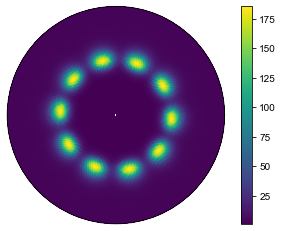

In [10]:
u,v = WPGAP(param_set)

In [ ]:
param_set_worst = [ 1.85910714, 12.17014355,  0.9824595 ,  2.23550661,  2.93285028,
        4.63197175]

In [ ]:
u,v = WPGAP(param_set_worst)